In [1]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
nltk.download('stopwords')

nltk.download('punkt')

# Global Parameters
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rgkri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rgkri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def load_dataset(filename, cols):
    dataset = pd.read_csv(filename, encoding='latin-1')
    dataset.columns = cols
    return dataset

In [3]:
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

In [4]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    #lemmatizer = WordNetLemmatizer()
    #lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(stemmed_words)

In [5]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [6]:
def int_to_string(sentiment):
    if sentiment == 0:
        return "Negative"
    elif sentiment == 2:
        return "Neutral"
    else:
        return "Positive"

In [7]:
# Load dataset
dataset = load_dataset("twitter_new.csv", ['target', 't_id', 'created_at', 'query', 'user', 'text'])
# Remove unwanted columns from dataset
n_dataset = remove_unwanted_cols(dataset, ['t_id', 'created_at', 'query', 'user'])
#Preprocess data
dataset.text = dataset['text'].apply(preprocess_tweet_text)
# Split dataset into Train, Test
dataset


,target,text
0,0,upset cant updat facebook text might cri resul...
1,0,i dive mani time ball manag save 50 the rest g...
2,0,whole bodi feel itchi like fire
3,0,behav im mad i cant see
4,0,whole crew
...,...,...
1599994,4,just woke have school best feel ever
1599995,4,thewdbcom veri cool hear old walt interview â «
1599996,4,are readi mojo makeov ask detail
1599997,4,happi 38th birthday boo alll time tupac amaru ...


In [9]:


# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(dataset.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(dataset.iloc[:, 1]).ravel())
y = np.array(dataset.iloc[:, 0]).ravel()

X


<1599999x387309 sparse matrix of type '<class 'numpy.float64'>'
	with 11746662 stored elements in Compressed Sparse Row format>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=30)
X_train

<1119999x387309 sparse matrix of type '<class 'numpy.float64'>'
	with 8221368 stored elements in Compressed Sparse Row format>

In [13]:

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))



0.7626


0.78264375


C:\Users\rgkri\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
y_predict_nb[y_predict_nb == 4] = 1
y_test[y_test == 4] = 1


array([1, 1, 0, ..., 0, 0, 0], dtype=int64)

In [ ]:
from sklearn.svm import SVC 
clf = SVC(kernel='linear') 
 
# fitting x samples and y classes 
clf.fit(X_train, y_train) 
y_predict_clf = clf.predict(X_test)
print(accuracy_score(y_test, y_predict_clf))

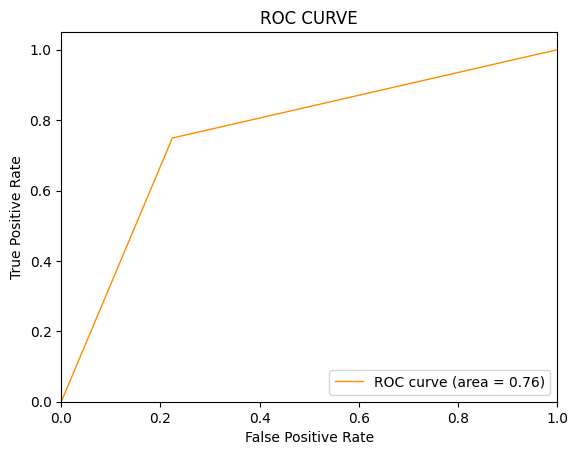

In [30]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_nb)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

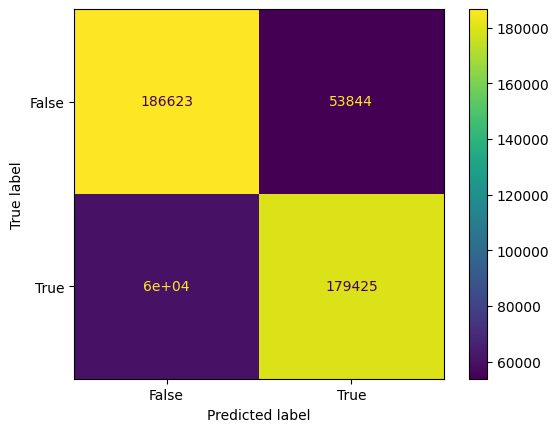

In [32]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_predict_nb)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()



In [34]:
precision = metrics.precision_score(y_test, y_predict_nb)
print("Precision :", precision)
recall = metrics.recall_score(y_test, y_predict_nb)
print("Recall    :", recall)
F1_score = metrics.f1_score(y_test, y_predict_nb)
print("F1-score  :", F1_score)

Precision : 0.7691763586245922
Recall    : 0.749061715922232
F1-score  : 0.7589857910922542


In [ ]:
# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)
y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

In [35]:
y_predict_lr[y_predict_lr == 4] = 1


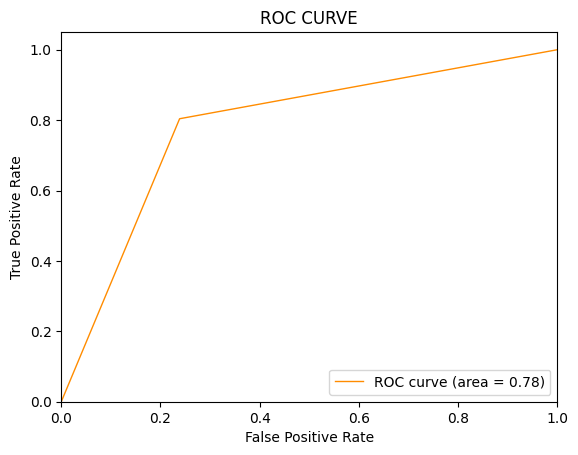

In [36]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_predict_lr)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

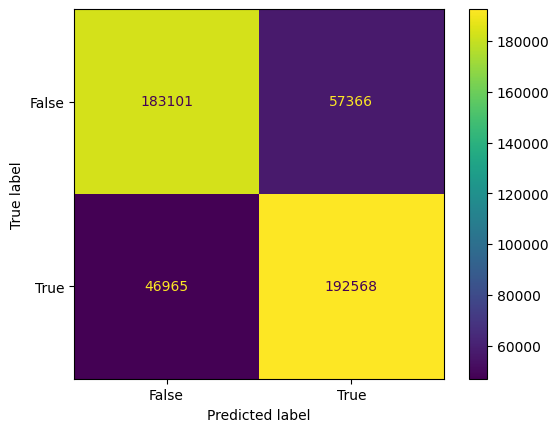

In [37]:
from sklearn import metrics
confusion_matrix = metrics.confusion_matrix(y_test, y_predict_lr)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()


In [38]:
precision = metrics.precision_score(y_test, y_predict_lr)
print("Precision :", precision)
recall = metrics.recall_score(y_test, y_predict_lr)
print("Recall    :", recall)
F1_score = metrics.f1_score(y_test, y_predict_lr)
print("F1-score  :", F1_score)

Precision : 0.7704754055070538
Recall    : 0.8039309823698614
F1-score  : 0.7868477343722866
